# Stockes Flow

Avec la méthode proposée de séparation de l'équation en deux équations couplées :


In [1]:
#importing libraries
import numpy
import numba
from numba import jit
from matplotlib import pyplot
%matplotlib inline

#defining grid
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

#initial guess
p = numpy.zeros((ny,nx))
w = numpy.zeros((ny,nx))

#dérivative of p along the top border
u=1.

l1_target = 1e-6

In [2]:
@jit
def L1norm(new, old):
    '''Calculate l1 norm between new and old
    
    Parameters:
    ----------
    new : Array of floats
        
    old : Array of floats
    
    Returns:
    -------
    norm : double
            value of the l1 Norm
    '''
    norm = numpy.sum(numpy.abs(new-old))
    return norm

In [3]:
@jit
def poisson_2d_1step(p, b, dx, dy):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    
    Returns:
    -------
    p_out: 2D array of float
        Distribution after relaxation
    '''
    p_out = p.copy()
   
    p_out[1:-1,1:-1] = 1.0/(2.0*(dx**2 + dy**2)) * ((p[1:-1,2:]+p[1:-1,:-2])*dy**2 + (p[2:,1:-1] + p[:-2,1:-1])*dx**2 - b[1:-1,1:-1]*dx**2*dy**2)
    
    #enforcing BC elsewhere
    return p_out

In [4]:
def laplace_2d_1step(p, dx, dy):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    dx: float
         spacing in x direction
    dy: float
        Mesh spacing in y direction
    
    Returns:
    -------
    p_out: 2D array of float
        Distribution after relaxation
    '''
    p_out = p.copy()
    
    p_out[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * ((p[1:-1,2:]+p[1:-1,:-2])*dy**2 + (p[2:,1:-1] + p[:-2,1:-1])*dx**2)
    
    #enforcing BC elsewhere   
    return p_out

In [5]:
@jit
def enforceBCphi(p):
    '''Enforce the boundary conditions for phi
    
    Parameters:
    ----------
    p : 2D array of floats
        solution before applying BC
    
    Returns:
    -------
    p_out : 2D array of floats
        solution after applying BC
    '''
#dirichlet condition
    p_out=p.copy()
    #top
    p_out[:,-1]=0.
    #bottom
    p_out[:,0]=0.
    #left
    p_out[0,:]=0.
    #right
    p_out[-1,:]=0.
    
    return p_out

In [6]:
def enforceBCw(w,p,dx,dy,u):
    '''Enforce boundary conditions for w
    
    Parameters:
    ----------
    w : solution before applying BC
    p : source term for bc
    dx : 
    
    
    Returns:
    -------
    w_out : solution after applying BC 
    '''
    
    #neumann + laplace
    w_out=w.copy()
    
    #bottom
    w_out[0,:]=-(8*p[1,:]-p[2,:])/2/dy/dy
    #top
    w_out[-1,:]=-(8*p[-2,:]-p[-3, :])/2/dy/dy - 3*u/dy
    #left
    w_out[:,0]=-(8*p[:,1]-p[:,2])/2/dx/dx
    #right
    w_out[:,-1]=-(8*p[:,-2]-p[:,-3])/2/dx/dx
    
    return w_out

In [7]:
#solve the biharmonic équation as a laplace and a poisson coupled equation
@jit
def biHarmonicSolver(p, w, dx, dy, l1Target, u):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array
        initial guess for p
    w : 2D array
        initial quess for w
    dx : float
        grid width in x
    dy : float
        grid width in y
    l1Target : float
        Target for the l1 norm between two iteration
    u : float
        parameter for bc
    
    Returns:
    -------
    p: 2D array
        solution for p
    w: 2D array
        solution for w
    l1phi : float
        l1 norm between two last iteration for p
    l1w : float
        l1 norm between two last iteration for w
    '''
    l1p=l1Target+1
    l1w=l1Target+1
    nbStep=0
    while l1p>l1Target or l1w>l1Target:
        p_old=p.copy()
        w_old=w.copy()
        p = poisson_2d_1step(p_old, -w_old, dx, dy)
        p = enforceBCphi(p)
        l1p= L1norm(p, p_old)
        w = laplace_2d_1step(w_old, dx, dy)
        w = enforceBCw(w, p, dx, dy, u)
        l1w=L1norm(w, w_old)
        nbStep=nbStep+1
        
    #those instruction are not really necessary but I was curious
    print("number of steps: ")
    print(nbStep)
    
    return p, w, l1p, l1w

In [8]:

p = numpy.zeros((ny,nx))
w = numpy.zeros((ny,nx))

#we solve équation and check the résult
p, w, l1phi, l1w = biHarmonicSolver(p, w, dx, dy, l1_target, u)
#we check that l1-norm is < target and print some value
print("L1 norm of p : ", l1phi, "L1 norm of w : ", l1w)
print("Some value for p")
print(p[32,::8])
print("Maximal Value of p")
print(numpy.max(numpy.abs(p)))
print("Maximal value of w :")
print(numpy.max(numpy.abs(w)))

number of steps: 
4060
L1 norm of p :  2.2423296094985696e-08 L1 norm of w :  9.997483223875715e-07
Some value for p
[ 0.         -0.05747874 -0.09442319 -0.09442319 -0.05747874  0.        ]
Maximal Value of p
0.0998451724622
Maximal value of w :
78.1926612286


<function matplotlib.pyplot.colorbar>

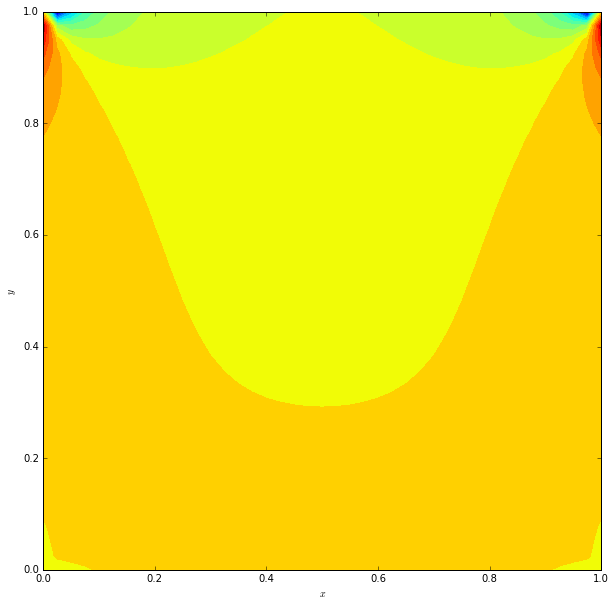

In [9]:
#print w
x=numpy.linspace(0, l, nx)
y=numpy.linspace(0, h, ny)
pyplot.figure(figsize=(10,10))
pyplot.contourf(x,y,w,20)
#pyplot.contourf(x, y, p, 20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar

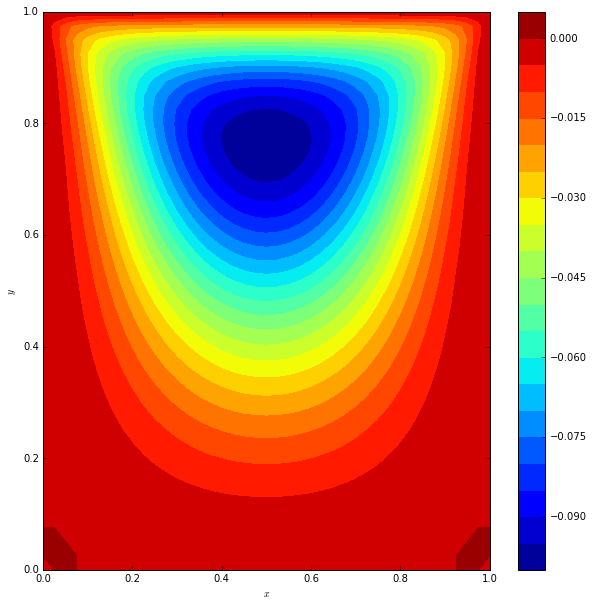

In [10]:
#print phi
x=numpy.linspace(0, l, nx)
y=numpy.linspace(0, h, ny)
pyplot.figure(figsize=(10,10))
#pyplot.contourf(x,y,w,20)
pyplot.contourf(x, y, p, 20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar()

## Conjugate Gradient Method


On peut discrétiser $\nabla ^4 = \partial ^4_x + 2\partial^2_x\partial^2_y + \partial^4_y$ de la manière suivante :

\begin{equation}
\nabla^4 u(i,j) = \frac{u(i+2, j) + u(i-2, j) + 6u(i, j) - 4 u(i+1, j) - 4u(i-1, j)}{dx^4} + \frac{u(i, j+2) + u(i, j-2) + 6u(i, j) - 4 u(i, j+1) - 4u(i, j-1)}{dy^4} + 2 \frac{u(i+1, j+1) + u (i+1, j-1) + u(i-1, j+1) + u(i-1, j-1) -2(u(i+1, j) + u(i-1, j) + u(i, j+1) + u(i, j-1)) +4u(i,j)}{dx^2 dy^2}
\end{equation}

Ce qui donne pour dx = dy :

\begin{equation}
\nabla^4 u(i,j) = [u(i+2, j) +u(i-2, j) + u(i, j+2) + u(i, j-2)) + 2 (u(i+1, j+1) + u (i+1, j-1) + u(i-1, j+1) + u(i-1, j-1)) -8 (u(i+1, j) + u(i-1, j) + u(i, j+1) + u(i, j-1)) + 20 u(i,j)]/dx^4
\end{equation}

ou $[...]^k$ signifie "évaluer la fonction au temps k"

Pour les conditions de Neumann au bord, on discretize simplement au 2ème ordre la dérivée première pour obtenir le résultat suivant :
\begin{equation}
u(i,j)^{k+1} = u(i, j-1)/4 - d_x u(i,j) *dx/2
\end{equation}

On a désormais tout en mains pour implémenter la méthode du gradient conjugué.

In [11]:
#defining grid
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

#initial guess
p = numpy.zeros((ny,nx))

#dérivative of p along the top border
u=1.

l1_target = 1e-6

In [12]:
def enforce_BC(u_old, v, dx):
    '''apply some boundary condition
    
    Parameters:
    ----------
    u_old : 2D array of floats
    v : parameter for boundary condition
    dy: float
        Mesh spacing in y direction
    Returns:
    -------
    u: 2D array of float
        Distribution after BC
    '''
    u = u_old.copy()
     #enforce neumann, dirichlet are automaticaly enforced
    u[1:-1,1]=u[1:-1,2]/4
    u[1:-1,-2]=u[1:-1,-3]/4
    u[1,1:-1]=2*u[2,1:-1]/4
    u[-2,1:-1]=u[-3,1:-1]/4 - v*dx/2
    
    return u

In [13]:
def biharmonic(u, v, dx):
    '''Calculate the biharmonic of a 2D array and apply some boundary condition
    
    Parameters:
    ----------
    p : 2D array of floats
    v : parameter for boundary condition
    dy: float
        Mesh spacing in y direction

        
    Returns:
    -------
    biharm: 2D array of float
        biharmonic of p
    '''
    #calculate de biharmonic of u
        #enforcing BC
    u=enforce_BC(u, v, dx)
    biharm=numpy.zeros(u.shape)
    biharm[2:-2,2:-2] = (u[2:-2,2:-2]*20 + u[4:,2:-2] +u[:-4, 2:-2] + u[2:-2, 4:] + u[2:-2, :-4] +\
                         2*(u[3:-1, 3:-1] + u[3:-1, 1:-3] + u[1:-3, 3:-1] + u[1:-3, 1:-3]) - \
                         8*(u[3:-1,2:-2] + u[1:-3, 2:-2] + u[2:-2, 3:-1] + u[2:-2, 1:-3]))/dx**4
    return biharm

In [14]:
def conjugate_gradient_2d(p, dx, dy, v, l1_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l1_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l1_norm = 1+l1_target
    iterations = 0
    l2_conv = []
    n=0
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    
    r = -biharmonic(p, v, dx)
    d = r.copy()
    rho = numpy.sum(d*d)
    Ad = biharmonic(d, v, dx)
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l1_norm > l1_target and n<10000:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma
        
        p = pk + alpha*dk
        r = rk- alpha*Ad
            
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        
        p=enforce_BC(p, 0, dx)
        
        Ad = biharmonic(d, v, dx)
        sigma = numpy.sum(d*Ad)

        l1_norm = L1norm(pk,p)
        iterations += 1
        l2_conv.append(l1_norm)
        n=n+1
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p, l2_conv    

In [15]:
p = numpy.zeros((ny,nx))
p, l2 = conjugate_gradient_2d(p, dx, dy, 1, l1_target)

Number of CG iterations: 1290


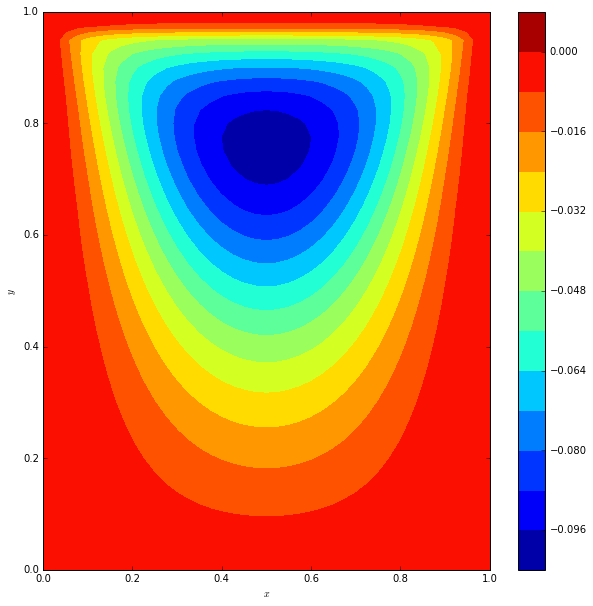

In [16]:
#print w
x=numpy.linspace(0, l, nx)
y=numpy.linspace(0, h, ny)
pyplot.figure(figsize=(10,10))
pyplot.contourf(x,y,p,15)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar()

In [17]:
print("Some value for p")
print(p[32,::8])
print("Maximal Value of p")
print(numpy.max(numpy.abs(p)))

Some value for p
[ 0.         -0.05735553 -0.09511717 -0.09511717 -0.05735553  0.        ]
Maximal Value of p
0.100818660391


Le résultat est légérement différent de celui précédent mais reste très proches. De olus, même si le gain n'est pas aussi spectaculaire que lors du traitement de l'équation de poisson, on a quand même un gain de l'ordre de 75%.

Néanmoins, je dois avouer que le travail sur les condition au bord à été ici très heuristique et la différence provient surement de là.